# Welcome to the AIMS Jupyter Notebook!
# As a refresher, hit ctrl + enter to run each cell
I tried to add comments and other markdown cells like this one where appropriate to help with interpretations. This first cell is just loading in all of the necessary python modules (which you should have already installed)

In [1]:
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as pl
from matplotlib import rcParams
from matplotlib import rc
import pandas

# THIS LAST BIT IS TO NAVIAGATE TO WHERE MY CUSTOM MODULES ARE LOCATED
import os
if os.getcwd()[-4:] != 'AIMS':
    default_path = os.getcwd()[:-10]
    os.chdir(default_path)
import aims_loader as aimsLoad
import aims_analysis as aims
import aims_classification as classy

# Here is the Notebook Version of the AIMS GUI
Mostly identical to what is going on inside the app, but you have a little bit more flexibility for customization. This notebook code should be quite flexible, and you really should only have to customize the below cell and then run the rest of the cells as-is.

In [2]:
# Define how many CDR loops are in the files you are loading
num_loop=3
# Define the names of the subgroups you are analyzing
label = ['poly','mono']

# Load in the files you want to analyze. Place the path to your directory in single quotes
# Ideally there won't be spaces in file or folder names. Check example files for proper formatting of csv or txt files
seq1 = aimsLoad.Ig_loader('app/ab_testData/flu_poly_heavy.csv',label=label[0],loops=num_loop,drop_degens = True)
seq2 = aimsLoad.Ig_loader('app/ab_testData/flu_mono_heavy.csv',label=label[1],loops=num_loop,drop_degens = True)

# If running on a mac, set parallel process to True for a speedup
# parallel processing has not yet been tested on other operating systems
parallel_process = False
# At one point we will break down our dataset into N top properties which best split these two subgroups
# Define that N here as "finalSize". Shouldn't make too large
# In classification applications must be particularly worried about overfitting with large N
finalSize = 10

# Next Few Cells are for Formatting
Just run them, you shouldn't need to change anything

In [3]:
mat_size1 = aims.get_sequence_dimension(np.array(seq1))[0]
mat_size2 = aims.get_sequence_dimension(np.array(seq2))[0]
if num_loop != 1:
    mat_size=np.zeros(len(mat_size1))
    for i in np.arange(len(mat_size1)):
        mat_size[i]=int(max(mat_size1[i],mat_size2[i]))
else:
    mat_size = max(mat_size1,mat_size2)

AA_num_key = aims.get_props()[1]

In [4]:
# You can edit these at some point if you want to change the formatting of your figures
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 20}
COLOR = 'black'
rcParams['text.color'] = 'black'
rcParams['axes.labelcolor'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR

rc('font', **font)

# Custom colormap code from: https://stackoverflow.com/questions/49367144/modify-matplotlib-colormap
import matplotlib as mpl
upper = mpl.cm.jet(np.arange(256))
lower = np.ones((int(256/4),4))
for i in range(3):
    lower[:,i] = np.linspace(1, upper[0,i], lower.shape[0])

cmap = np.vstack(( lower, upper ))
cmap = mpl.colors.ListedColormap(cmap, name='myColorMap', N=cmap.shape[0])

In [5]:
if num_loop != 1:
    for i in np.arange(len(mat_size)):
        if i == 0:
            xtick_loc = [mat_size[i]/2]
        else:
            pre_loc = sum(mat_size[:i])
            xtick_loc = xtick_loc + [mat_size[i]/2 + pre_loc]
else:
    xtick_loc = mat_size/2

# ALIGNMENT OPTIONS are bulge, center, left, and right... pretty self explanatory besides bulge
Bulge aligns the germline regions of CDR3 (and other loops) and then center aligns what is left. Change the 'align' variable to one of these three. Pretty easy to visualize each time you do so in below matrix

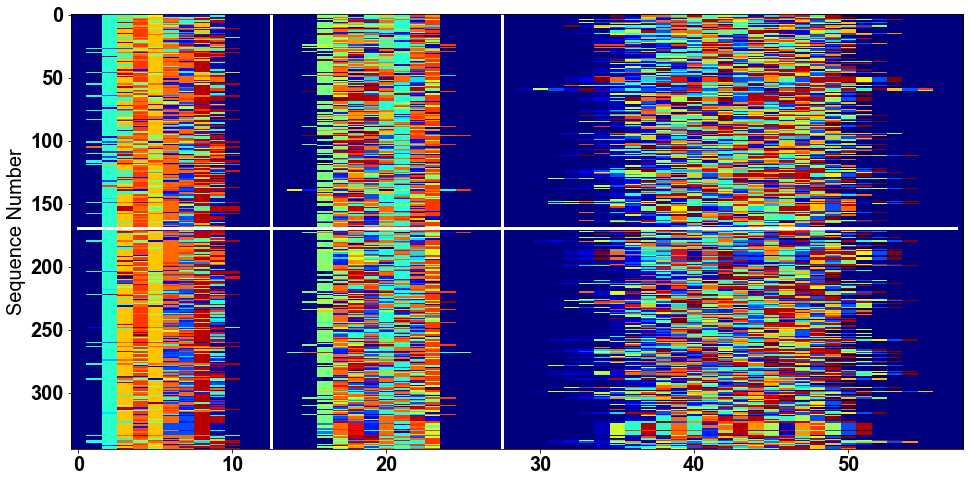

In [6]:
# Here we are getting the data into an AIMS-readable format... A numpy matrix
align = 'center'
seq_MI1 = aims.gen_tcr_matrix(np.array(seq1),key = AA_num_key, giveSize = mat_size, alignment = align)
seq_MI2 = aims.gen_tcr_matrix(np.array(seq2),key = AA_num_key, giveSize = mat_size, alignment = align)
seq_MIp1 = pandas.DataFrame(np.transpose(seq_MI1),columns = seq1.columns)
seq_MIp2 = pandas.DataFrame(np.transpose(seq_MI2),columns = seq2.columns)
seq_MIf = pandas.concat([seq_MIp1,seq_MIp2],axis=1)
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
ax[0,0].imshow(np.transpose(seq_MIf), interpolation='nearest', aspect='auto',cmap=cm.jet)
ax[0,0].set_ylabel('Sequence Number')

# Plot a single line delineating the distinct groups we are studying.
ax[0,0].plot(np.arange(len(seq_MIf)),np.ones(len(seq_MIf))*len(seq_MI1),'white',linewidth = 3)
######
# It will help to have vertical white lines to guide the viewer
seq1_len = np.shape(seq1)[1]; seq2_len = np.shape(seq2)[1]
Numclones = int(seq1_len + seq2_len)
if type(mat_size) != int:
    for i in np.arange(len(mat_size)-1):
        ax[0,0].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(Numclones),np.arange(Numclones),'white',linewidth = 3)
#######

if num_loop == 1:
    ax[0,0].set_xlabel('Sequence Position')
elif num_loop == 2:
    ax[0,0].set_xticks(xtick_loc)
    ax[0,0].set_xticklabels(['CDR3L','CDR3H'])
elif num_loop == 6:
    ax[0,0].set_xticks(xtick_loc)
    ax[0,0].set_xticklabels(['CDR1L','CDR2L','CDR3L','CDR1H','CDR2H','CDR3H'])
# Can also edit the saved figure name and format, if you want
#pl.savefig('AIMS_mat.pdf',format='pdf')

In [7]:
# Process this new matrix and apply biophysical propery "masks"
dsetF = np.hstack((seq1.values,seq2.values))
#################### PARALLEL PROCESSING TO CREATE BIG MATRIX #######################
if parallel_process:
    import multiprocessing as mp
    def boot_it(data):
        bigass = classy.get_bigass_matrix(dsetF[:,data[0]:data[1]], giveSize = mat_size, alignment = align, norm=True)
        return(bigass)
    def do_boot(data):
        with mp.Pool() as pool:
            results = pool.map(boot_it, data)
            return(results)
    if __name__ == "__main__":
        # Probably a smarter way to calculate #seqs per node, but do 100 for now
        final = aims.gen_splits(splitMat = seq_MIf, splitSize = 100)
        big_pre = do_boot(final)
    # Still need to input seq1/seq2 for 
    full_big, weights, acc_all, mda_all, parsed_mat, top_names = aims.compile_MP(big_pre, seq1.values, seq2.values, final_size = finalSize)
else:

    full_big, weights, acc_all, mda_all, parsed_mat, top_names= classy.do_linear_split(seq1.values, seq2.values, 
                                                                           giveSize = mat_size, ridCorr = True, matSize = finalSize, align=align)

# In the Original Analysis, the Whole Goal was Classification
For many other analyses, this may not be quite as important. Just in case, the below cell is for visualizing how well a classifier *might* work. In future updates, hopefully I can automate the creation of a classifier a little bit. For now I'd refer you to your favorite home-institution bioinformatician (or you can try reaching out to form a collaboration!)

<AxesSubplot:xlabel='Dataset', ylabel='Linear Discriminant 1'>

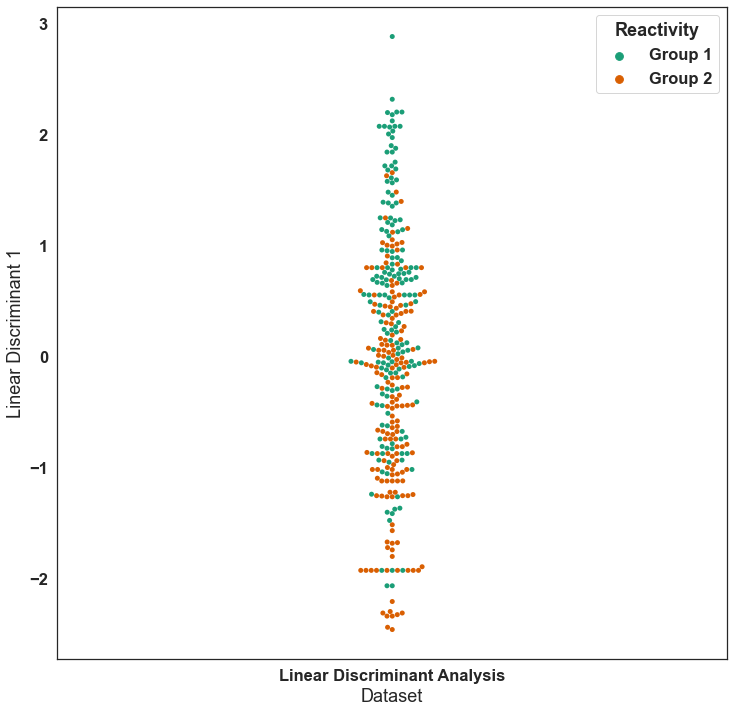

In [8]:
import seaborn as sns
fig = pl.figure(figsize = (12, 12))
dset = ["Linear Discriminant Analysis" for x in range(seq1_len+seq2_len)]
reacts = ["Group 1" for x in range(seq1_len)] + ["Group 2" for x in range(seq2_len)]

d1 = {'Dataset': dset, 'Linear Discriminant 1': mda_all.reshape(len(mda_all)),
    'Reactivity' : reacts}
df1 = pandas.DataFrame(data=d1)
sns.set(style="white", color_codes=True,font_scale=1.5)
sns.swarmplot(x="Dataset", y="Linear Discriminant 1", data=df1, hue = 'Reactivity', palette = "Dark2")
#pl.savefig('AIMS_mda.pdf',format='pdf')

In [9]:
# One last little bit of reformatting here
seq1_bigF, seq2_bigF = aims.split_reshape(full_big, matShape = len(seq_MIf), total_props = 61)
# Which property will you want to look at down the line? 1 = charge, 2 = hydrophobicity... see full list in eLife paper (Boughter et al. 2020)
prop1 = 1

# Now we've done all of the pre-processing, generate figures next

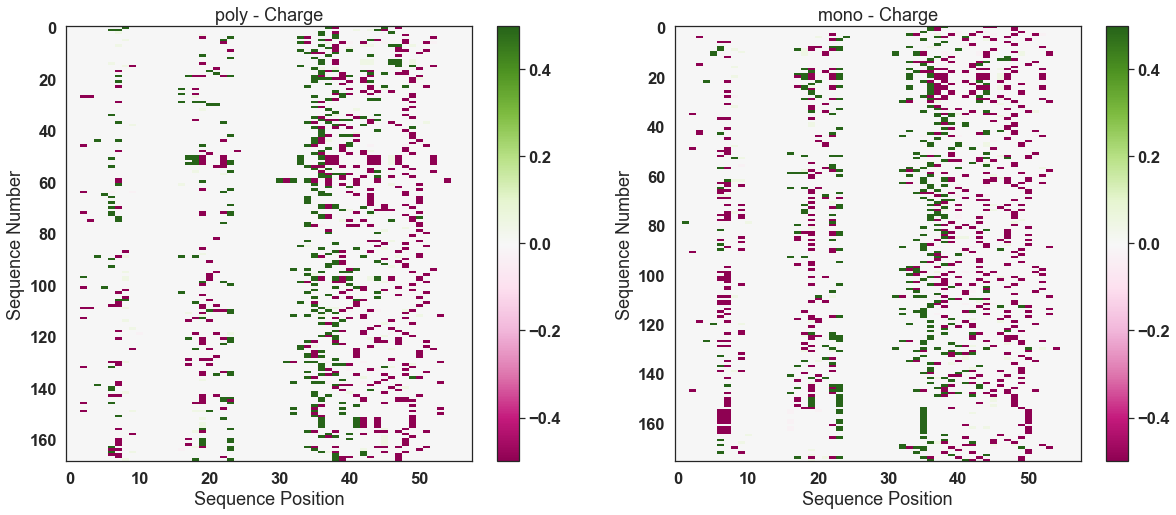

In [10]:
# Generate the position sensitive charge across all clones in the dataset
fig, axs = pl.subplots(1, 2,squeeze=False,figsize=(20,8))
ax1 = axs[0, 0]; ax2 = axs[0, 1]
x = ax1.imshow(seq1_bigF[:,prop1,:],interpolation='nearest', aspect='auto',cmap=cm.PiYG)
y = ax2.imshow(seq2_bigF[:,prop1,:],interpolation='nearest', aspect='auto',cmap=cm.PiYG)
ax1.set_xlabel('Sequence Position'); ax2.set_xlabel('Sequence Position')
ax1.set_ylabel('Sequence Number'); ax2.set_ylabel('Sequence Number')
ax1.set_title(label[0] + ' - Charge'); ax2.set_title(label[1] + ' - Charge')
fig.colorbar(x, ax=axs[0,0]); fig.colorbar(y, ax=axs[0,1])
#pl.savefig('AIMS_propMat.pdf',format='pdf')

Text(0, 0.5, 'Normalized Property Value')

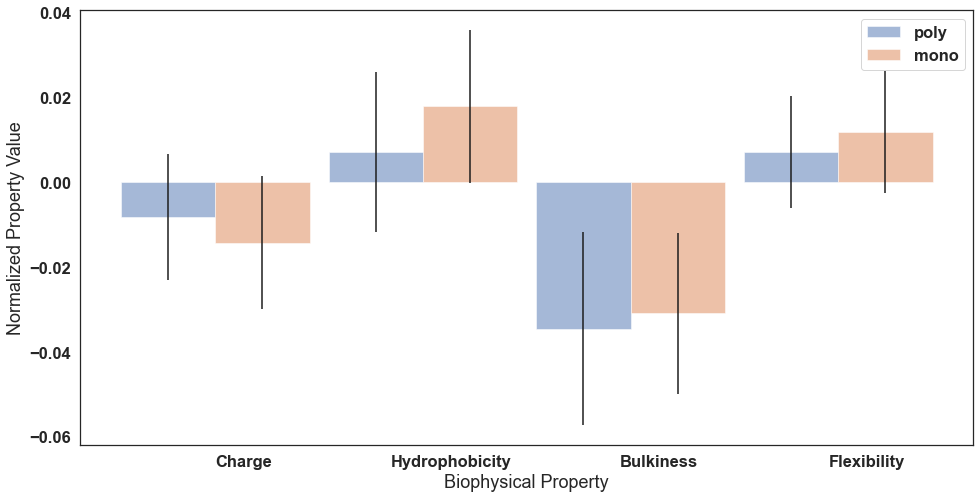

In [11]:
# Look at biophysical properties averaged over clones AND position
# Note for old users of the software, you might get different looking results because
# originally I normalized vectors to unit length, but NOT 0 mean. I now do both.
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
x_axis = np.array([-0.2,0.9,2,3.1])
# Need to have some kind of color wheel to replace this...
# We want to exclude prop0 (the simple 1-21 AA representation entries)
for prop in np.arange(4):
    propF = prop+1
    plotProp1 = np.average(np.average(seq1_bigF[:,propF,:],axis = 1))
    plotProp2 = np.average(np.average(seq2_bigF[:,propF,:],axis = 1))
    plotstd1 = np.std(np.average(seq1_bigF[:,propF,:],axis = 1))
    plotstd2 = np.std(np.average(seq2_bigF[:,propF,:],axis = 1))
    if prop == 0:
        plot1 = plotProp1; std1 = plotstd1
        plot2 = plotProp2; std2 = plotstd2
    else:
        plot1 = np.hstack((plot1,plotProp1)); std1 = np.hstack((std1,plotstd1))
        plot2 = np.hstack((plot2,plotProp2)); std2 = np.hstack((std2,plotstd2))
        
ax[0,0].bar(x_axis, plot1,
            yerr = std1,alpha = 0.5, width = 1/len(label))
ax[0,0].bar(x_axis+1/len(label), plot2,
            yerr = std2,alpha = 0.5, width = 1/len(label))
        
ax[0,0].legend(label)
ax[0,0].set_xticks([0.2,1.3,2.4,3.5])
ax[0,0].set_xticklabels(['Charge','Hydrophobicity','Bulkiness','Flexibility'])
ax[0,0].set_xlabel('Biophysical Property')
ax[0,0].set_ylabel('Normalized Property Value')
#pl.savefig('AIMS_netProp.pdf',format='pdf')

Text(0, 0.5, 'Normalized Hydrophobicity')

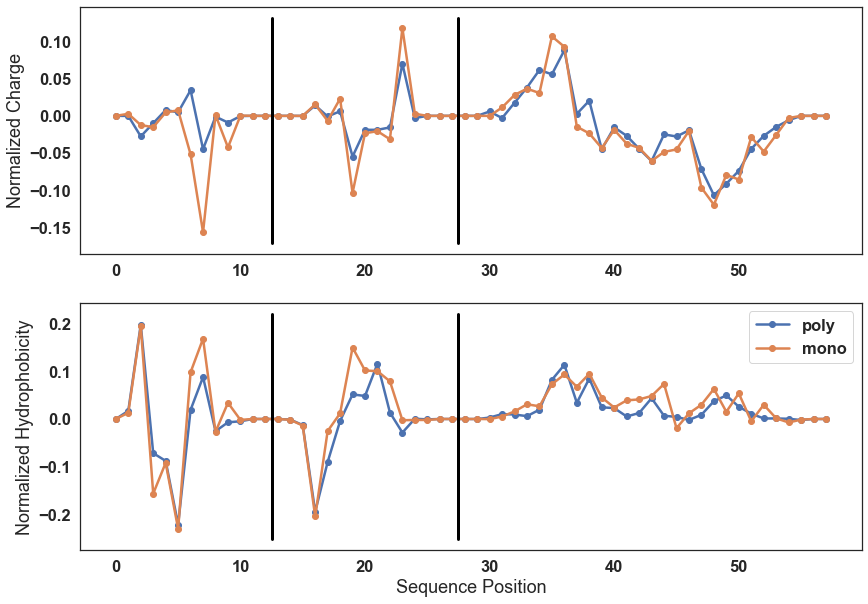

In [12]:
# Now get the position sensitive avarege biophysical properties
fig, ax = pl.subplots(2, 1,squeeze=False,figsize=(14,10))
prop1 = 1
plotProp11 = np.average(seq1_bigF[:,prop1,:],axis = 0); plotProp21 = np.average(seq2_bigF[:,prop1,:],axis = 0)
ax[0,0].set_ylabel('Charge')
ax[0,0].plot(plotProp11,marker='o',linewidth=2.5); ax[0,0].plot(plotProp21,marker='o',linewidth=2.5)

prop2 = 2
plotProp12 = np.average(seq1_bigF[:,prop2,:],axis = 0); plotProp22 = np.average(seq2_bigF[:,prop2,:],axis = 0)
ax[1,0].set_ylabel('Hydrophobicity'); ax[1,0].plot(plotProp12,marker='o',linewidth=2.5)
ax[1,0].plot(plotProp22,marker='o',linewidth=2.5); ax[1,0].set_xlabel('Sequence Position')
pl.legend(label)

# Draw some nice lines to guide 
y11, y12 = ax[0,0].get_ylim();y21, y22 = ax[1,0].get_ylim()
if type(mat_size) != int:
    for i in np.arange(len(mat_size)-1):
        ax[0,0].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100),np.linspace(y11,y12,100),'black',linewidth = 3)
        ax[1,0].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100),np.linspace(y21,y22,100),'black',linewidth = 3)

ax[0,0].set_ylabel('Normalized Charge')
ax[1,0].set_ylabel('Normalized Hydrophobicity')
#pl.savefig('AIMS_posProp.pdf',format='pdf')

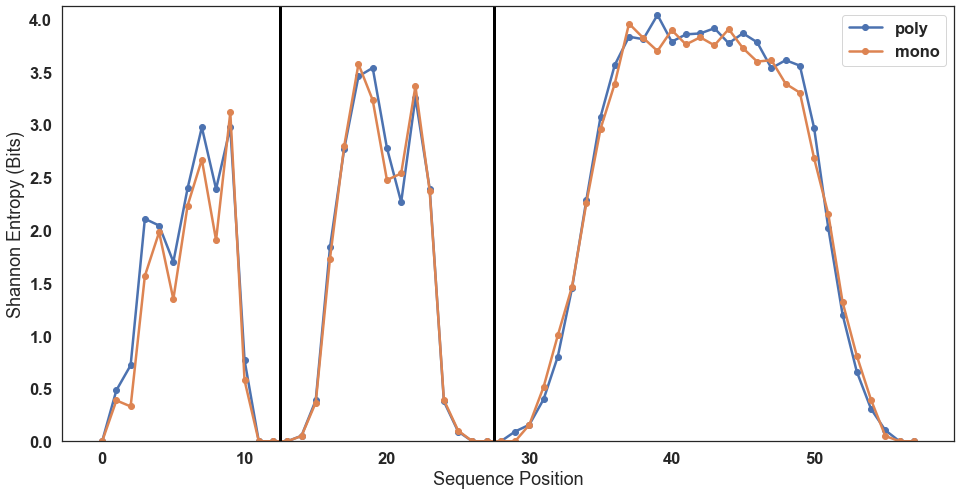

In [13]:
# Calculate the Shannon Entropy, a proxy for diversity
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
poses = len(seq_MIf)
frequencies = np.zeros((len(label),poses,21))
for i in np.arange(len(label)):
    index = [column for column in seq_MIf.columns if label[i] in column]
    subset = np.array(seq_MIf[index])
    entropy,AA_count=aims.calculate_shannon(np.transpose(subset))
    frequencies[i] = AA_count
    pl.plot(entropy,marker='o',linewidth=2.5)

pl.legend(label); pl.xlabel('Sequence Position'); pl.ylabel('Shannon Entropy (Bits)')
# Entropy is a rare case where we know the exact bounds of the values...
# Comment this out if your max entropy is substantially lower
pl.ylim([0,4.12])
# Guide the eyes with these lines
if type(mat_size) != int:
    for i in np.arange(len(mat_size)-1):
        ax[0,0].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100),np.linspace(0,4.2,100),'black',linewidth = 3)

#pl.savefig('AIMS_shannon.pdf',format='pdf')

Text(0.5, 1.0, 'mono')

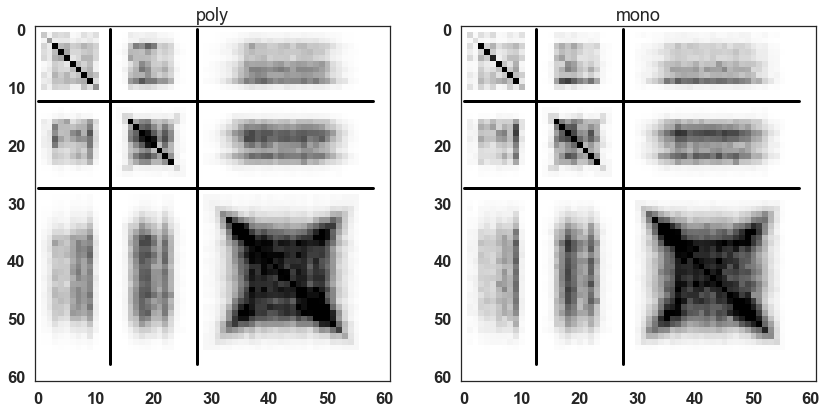

In [14]:
# And then the mutual information:
# NOTE FOR FUTURE: Probably could stand to parallelize this...
fig, ax = pl.subplots(1, 2,squeeze=False,figsize=(14,10))
MI_master = np.zeros((len(label),poses,poses))
for i in np.arange(len(label)):
    index = [column for column in seq_MIf.columns if label[i] in column]
    subset = np.array(seq_MIf[index])
    MI,entropy_cond,counted=aims.calculate_MI(np.transpose(subset))
    MI_master[i] = MI
    if i > 3:
        continue
    # NOTE, CHANGE VMAX HERE IF SIGNAL IS BLOWN OUT/TOO DIM
    ax[0,i].imshow(MI,vmin=0,vmax=1.5,cmap=cm.Greys)

# Help Guide the eyes a bit
if type(mat_size) != int:
    for i in np.arange(len(mat_size)-1):
        ax[0,0].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100),np.linspace(0,poses,100),'black',linewidth = 3)
        ax[0,0].plot( np.linspace(0,poses,100), (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100) ,'black',linewidth = 3)
        ax[0,1].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100),np.linspace(0,poses,100),'black',linewidth = 3)
        ax[0,1].plot( np.linspace(0,poses,100), (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100) ,'black',linewidth = 3)

ax[0,0].set_title(label[0])
ax[0,1].set_title(label[1])
#pl.savefig('AIMS_MI.pdf',format='pdf')

Text(0, 0.5, 'Sequence Position')

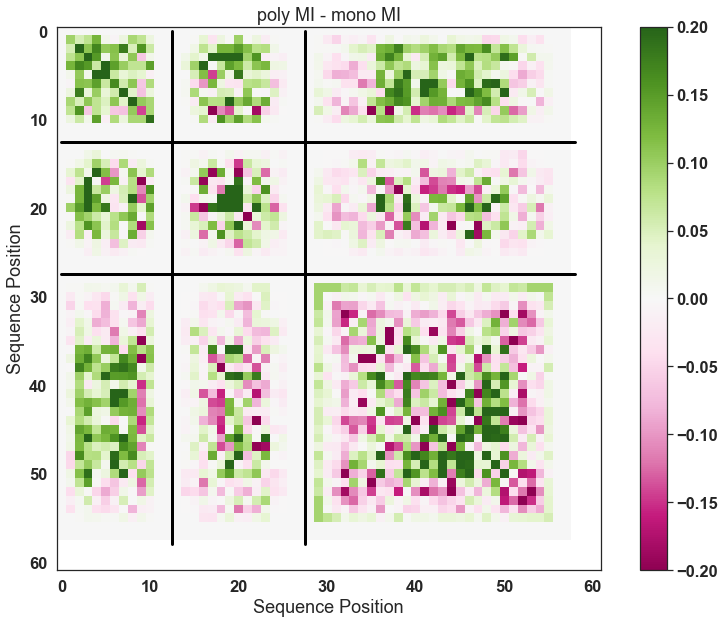

In [15]:
# A bit easier to look at the DIFFERENCE in mutual information:
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(14,10))
x = pl.imshow(MI_master[0] - MI_master[1], cmap=cm.PiYG, vmin = -0.2, vmax = 0.2)
pl.colorbar(x); pl.title(label[0]+ ' MI - ' + label[1] + ' MI')

# Help Guide the eyes a bit
if type(mat_size) != int:
    for i in np.arange(len(mat_size)-1):
        ax[0,0].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100),np.linspace(0,poses,100),'black',linewidth = 3)
        ax[0,0].plot( np.linspace(0,poses,100), (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100) ,'black',linewidth = 3)

pl.xlabel('Sequence Position'); pl.ylabel('Sequence Position')
#pl.savefig('AIMS_MIdiff',format='pdf')

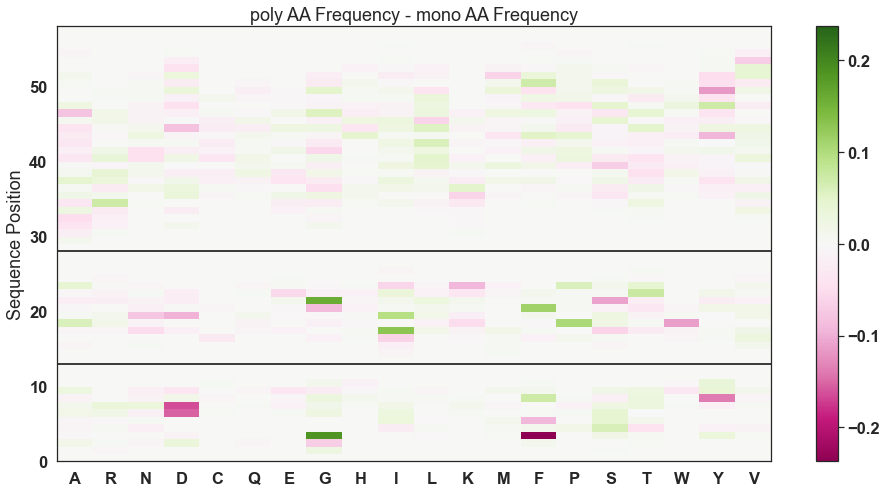

In [16]:
# Calculate the probabilities of seeing each amino acid at each position
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
pl.title(label[0]+ ' AA Frequency - ' + label[1] + ' AA Frequency')
freqMax = np.max(frequencies[0,:,1:]-frequencies[1,:,1:]); freqMin = np.min(frequencies[0,:,1:]-frequencies[1,:,1:])
freqBound = max(abs(freqMax),abs(freqMin))
x=ax[0,0].pcolormesh(frequencies[0,:,1:]-frequencies[1,:,1:],vmin=-freqBound,vmax=freqBound,cmap=cm.PiYG)
AA_key=['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V']
pl.colorbar(x); pl.ylabel('Sequence Position')
xax=pl.setp(ax,xticks=np.arange(20)+0.5,xticklabels=AA_key)

place=0
if type(mat_size) == int:
    pl.plot(np.arange(21),place*np.ones(21),'black')
else:
    for i in mat_size:
        place += i
        pl.plot(np.arange(21),place*np.ones(21),'black')

#pl.savefig('AIMS_AAprob.pdf', format='pdf')# dpi=1000)

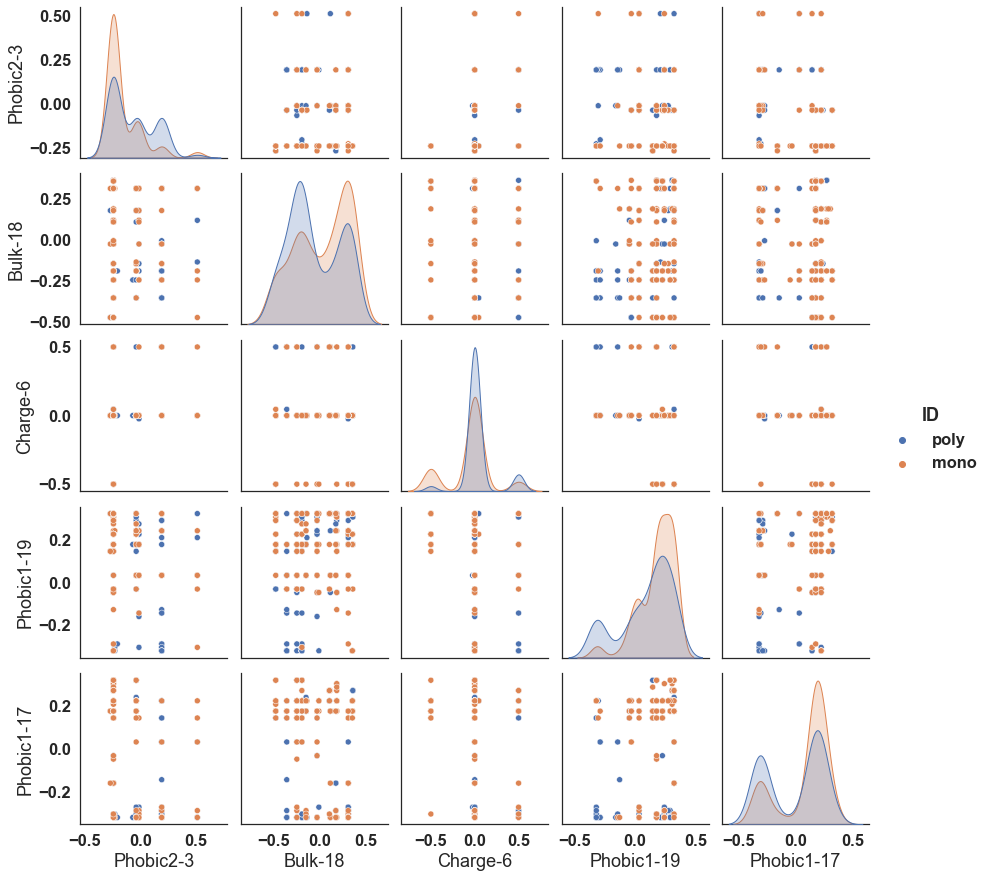

In [17]:
# Show the top properties that differentiate the two populations
# show_top = how many of these top values do you want to show? don't recommend more than ~5
# solely due to how busy the figure gets
# Again, see eLife paper for biophysical property definitions
show_top = 5
dset_parse = parsed_mat[top_names[0:show_top]]
dset_ID_pre1 = full_big['ID']
dset_ID_pre2 = dset_ID_pre1.replace(1.0,label[0])
dset_ID = dset_ID_pre2.replace(2.0,label[1])

bigass_parse_dset = pandas.concat([dset_parse,dset_ID],axis = 1)
sns.pairplot(bigass_parse_dset,hue = 'ID')
#pl.savefig('AIMS_pairplot.pdf', format='pdf')# dpi=1000)

# The next few cells are particularly powerful for isolating interesting populations in each dataset using PCA, UMAP, and KMeans Clustering
If you notice patterns in one particular dataset, might be worth porting over to the AIMS_single notebook for the careful characterization of certain populations of interest in singular datasets. Again, you really shouldn't need to change ANYTHING save for the number of clusters in each clustering instance and the few specific populations you may want to look at more closely

[0.04011205 0.03530232 0.02691958]


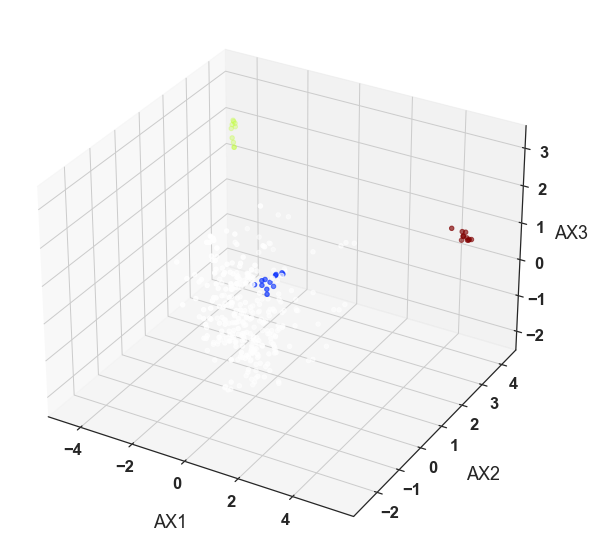

In [18]:
# Perform UMAP on the whole dataset?
#chosen_dset = full_big.drop(columns='ID')
# Or perform it on the dataset with correlated vectors removed?
chosen_dset = parsed_mat

# Want to run pca, tsne, or umap?
reduce = 'pca'
# What will you cluster with (kmean, optics, dbscan)?
clust = 'optics'

if reduce == 'pca':
    from sklearn.decomposition import PCA
    pca = PCA(n_components=3, svd_solver='full')
    final=pca.fit_transform(chosen_dset)
    transform = pandas.DataFrame(np.transpose(final),columns = seq_MIf.columns)
    print(pca.explained_variance_ratio_)
elif reduce == 'umap':
    import umap
    reducer = umap.UMAP(n_components=3, n_neighbors = 25, n_jobs = 1, random_state = 47)
    final = reducer.fit_transform(chosen_dset)
    transform = pandas.DataFrame(np.transpose(final),columns = seq_MIf.columns)
elif reduce == 'tsne':
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components = 3, init = 'pca', random_state = 47, n_jobs = 1)
    final=tsne.fit_transform(chosen_dset)
    transform = pandas.DataFrame(np.transpose(final),columns = seq_MIf.columns)
    
from mpl_toolkits import mplot3d
fig3d = pl.figure(figsize = (10, 10))
ax3d = fig3d.add_subplot(111, projection='3d')

# Cluster the results:
clust_input = np.array(np.transpose(transform))
import sklearn.cluster as cluster
if clust == 'kmean':
    NClust = 5
    clusts = cluster.KMeans(n_clusters=NClust).fit_predict(clust_input)
elif clust == 'optics':
    clusts = cluster.OPTICS(min_samples=10).fit_predict(clust_input)
elif clust == 'dbscan':
    clusts = cluster.DBSCAN(eps=0.5).fit_predict(clust_input)

cluster_dset = pandas.DataFrame(clusts,columns=['cluster'])
# Want the min cluster to be white for non kmean cluster, as these are unclustered
if clust == 'kmean':
    ax3d.scatter(clust_input[:,0],clust_input[:,1],clust_input[:,2],c = clusts, cmap='rainbow')
else:
    ax3d.scatter(clust_input[:,0],clust_input[:,1],clust_input[:,2],c = clusts, cmap=cmap)

ax3d.set_xlabel('AX1',labelpad=20)
ax3d.set_ylabel('AX2',labelpad=20)
ax3d.set_zlabel('AX3',labelpad=10)
#pl.savefig('AIMS_PCA3D.pdf',DPI=500,format='pdf')
pl.show()

Text(0, 0.5, 'AX2')

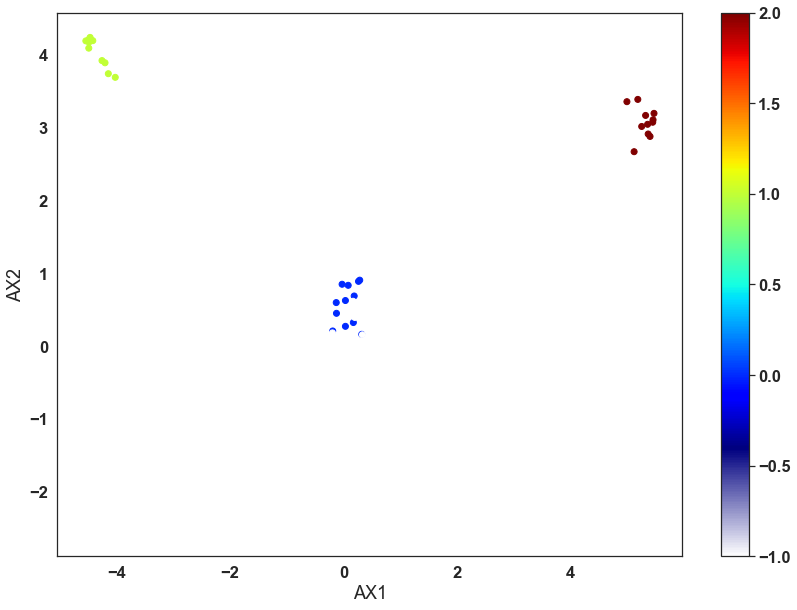

In [19]:
fig = pl.figure(figsize = (14, 10))
if clust == 'kmean':
    x = pl.scatter(clust_input[:,0],clust_input[:,1],c = clusts, cmap='rainbow')
else:
    x = pl.scatter(clust_input[:,0],clust_input[:,1],c = clusts, cmap=cmap)

zz = pl.colorbar(x)    
pl.xlabel('AX1'); pl.ylabel('AX2')
#pl.savefig('AIMS_PCA2D.pdf',format='pdf')

# For every clustering, we can replot the original matrix to find patterns in the data (agnostic of which user-defined group they belong to)
Then, in the section after, we can go back and find the # of entries from each group in each cluster

Text(0, 0.5, 'Sequence Number')

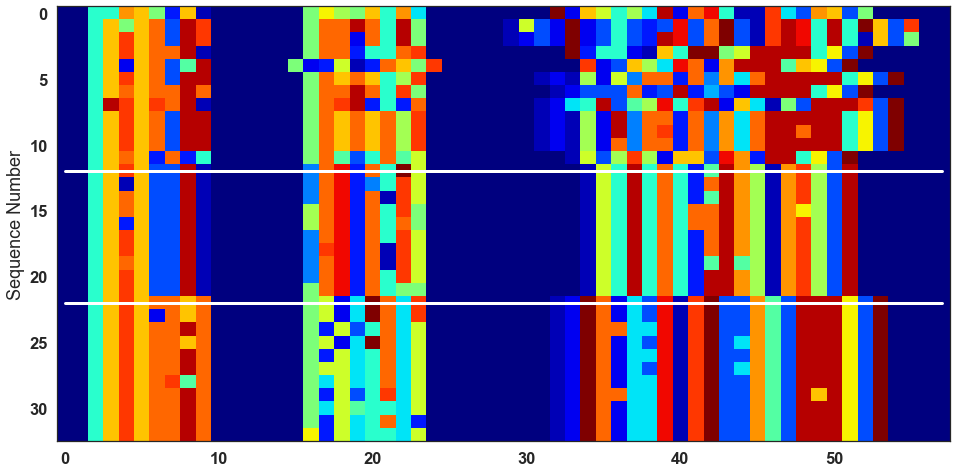

In [20]:
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
fin_clustL = len(cluster_dset['cluster'].drop_duplicates())
cluster_bins = np.zeros((fin_clustL,len(label)))
for i in np.sort(cluster_dset['cluster'].drop_duplicates()):
    pre_clust = seq_MIf[seq_MIf.columns[cluster_dset[cluster_dset['cluster'] == i].index]]
    clustID = np.transpose(pandas.DataFrame(i*np.ones(np.shape(pre_clust)[1])))
    clustID.columns = pre_clust.columns
    pre_clustF = pandas.concat([pre_clust,clustID],axis=0)
    for j in np.arange(len(label)):
            index = [column for column in clustID.columns if label[j] in column]
            cluster_bins[i,j] = np.shape(clustID[index])[1]
    if i == -1:
        continue
    if i == 0:
        clustered = pre_clustF
    else:
        clustered = pandas.concat([clustered, pre_clustF],axis = 1)
    ax[0,0].plot(np.arange(len(seq_MIf)),np.ones(len(seq_MIf))*(np.shape(clustered)[1]),'white',linewidth = 3)

xyz = ax[0,0].imshow(np.transpose(np.array(clustered))[:,:-1], interpolation='nearest', aspect='auto',cmap=cm.jet)
ax[0,0].set_ylabel('Sequence Number')
#pl.savefig('AIMS_clustMat.pdf',format='pdf')

# Unclustered Sequences: 312


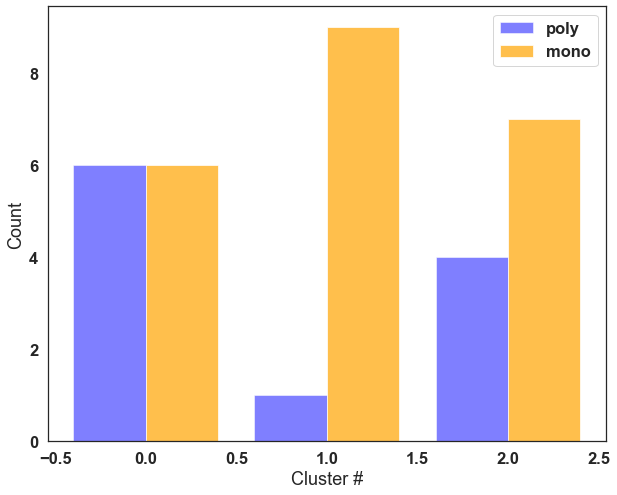

In [21]:
# Find representative entries from the clusters
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(10,8))
final_breakdown = pandas.concat([chosen_dset,dset_ID, cluster_dset],axis=1)
# auto-identify number of clusters
n1 = 0; n2 = 0
for i in np.sort(final_breakdown['cluster'].drop_duplicates()):
    num = final_breakdown[final_breakdown['cluster'] == i]
    # Skip unclustered data... but print # unclustered
    if i == -1:
        print('# Unclustered Sequences: ' + str(len(num)))
        continue
    pl.bar(i-0.2,len(num[num['ID'] == label[0]]),color='blue',width=0.4,alpha = 0.5)
    pl.bar(i+0.2,len(num[num['ID'] == label[1]]),color='orange',width=0.4,alpha = 0.7)
pl.xlabel('Cluster #')
pl.ylabel('Count')
pl.legend(label)
#pl.savefig('AIMS_pcacluster_count.pdf',format='pdf')

# As a final section, we can isolate individual clusters from UMAP or PCA for further inspection
Run the next cell to visualize certain clusters, then the cell after to save these sequences in separate files and potentially use seqlogo to visualize.

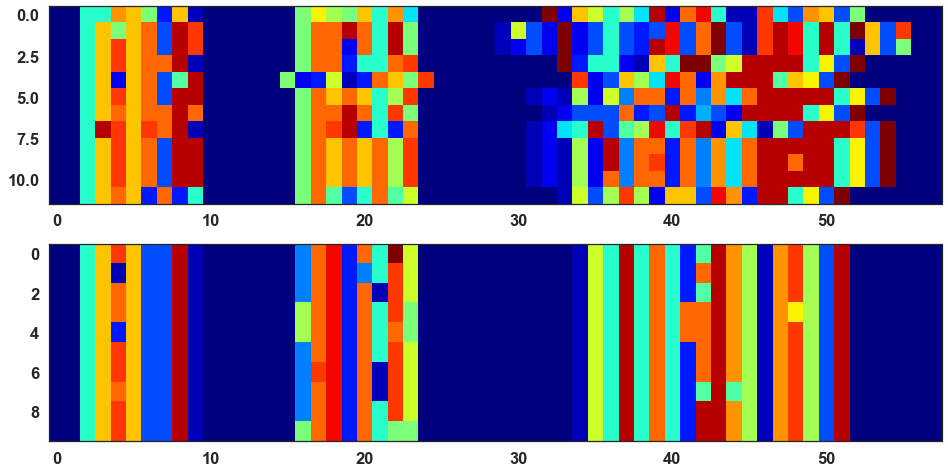

In [22]:
# So now that we've done some clustering, pick out the most interesting clusters:
sel1 = 0
sel2 = 1
# Look at umap dset or pca dset
sub1_MI = seq_MIf[seq_MIf.columns[cluster_dset[cluster_dset['cluster'] == sel1].index]]
sub2_MI = seq_MIf[seq_MIf.columns[cluster_dset[cluster_dset['cluster'] == sel2].index]]

# Alright now get the sequences
dset_sub = pandas.concat([seq1,seq2],axis=1)
sub1_seqs = np.transpose(dset_sub[sub1_MI.columns])
sub2_seqs = np.transpose(dset_sub[sub2_MI.columns])

label_sub=['sub1','sub2']

fig, ax = pl.subplots(2, 1,squeeze=False,figsize=(16,8))
ax[0,0].imshow(np.transpose(sub1_MI), interpolation='nearest', aspect='auto',cmap=cm.jet)
ax[1,0].imshow(np.transpose(sub2_MI), interpolation='nearest', aspect='auto',cmap=cm.jet)
#pl.savefig('AIMS_2groupMat.pdf',format='pdf')

In [23]:
# Alright now that we know we're looking at the clusters we are interested in, analyze!
# We need to single out sequences of a singular length for seqlogo analysis... Can't analyze different lengths
seqlogo1 = sub1_seqs[sub1_seqs[2].str.len() == 21]
seqlogo2 = sub2_seqs[sub2_seqs[2].str.len() == 22]
# seqlogo takes a stripped down input:
seqlogo1.to_csv(label_sub[0]+'_logo.txt',header=None,index=None)
seqlogo2.to_csv(label_sub[1]+'_logo.txt',header=None,index=None)

# Do you want the full list of sequences? Do this:
sub1_seqs.to_csv(label_sub[0]+'_all.txt',header=None,index=None)
sub2_seqs.to_csv(label_sub[1]+'_all.txt',header=None,index=None)

# Can take the "subset_all.txt" outputs and load them into this same analysis pipeline for comparison

# Only run the next cell if you have seqlogo installed
You can download command line seqlogo here: https://weblogo.berkeley.edu/

In [24]:
%%bash
# Alright let's cheat and just use the seqlogo in bash... the python script is a little bit of a pain.
# Code is from reference: 
#Crooks GE, Hon G, Chandonia JM, Brenner SE WebLogo: A sequence logo generator, Genome Research, 14:1188-1190, (2004)

# Obviously, change this path to wherever YOUR seqlogo is.
#weblogo/seqlogo -F PDF -c -n -Y -f sub1_logo.txt > sub1_logo.pdf
#weblogo/seqlogo -F PDF -c -n -Y -f sub2_logo.txt > sub2_logo.pdf